c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Original Model Accuracy: 0.6896551724137931
L1 Regularized Model Accuracy: 0.6724137931034483
L2 Regularized Model Accuracy: 0.7068965517241379


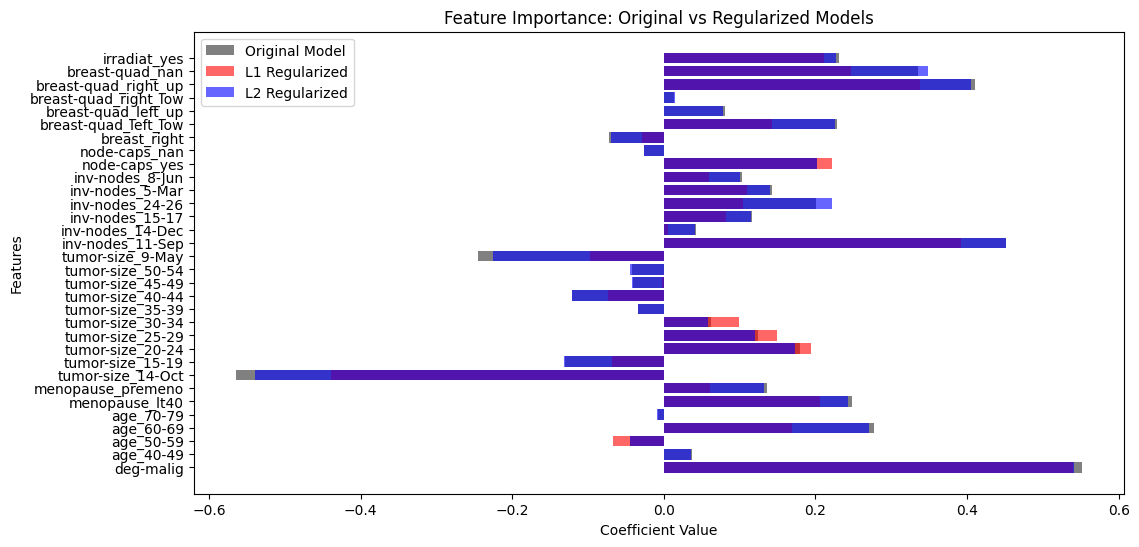

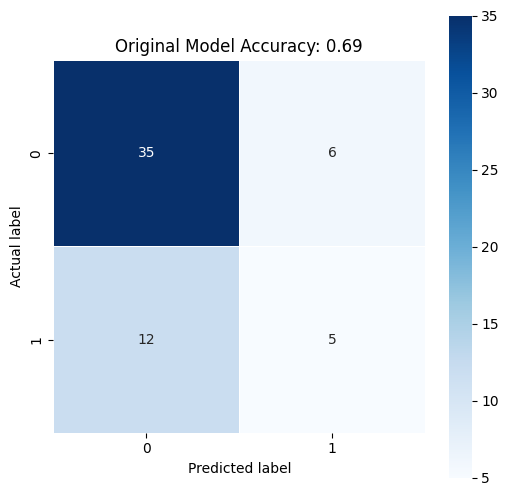

In [1]:
# Data preprocessing and exploration
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ucimlrepo import fetch_ucirepo

# Fetch and prepare data
dataset = fetch_ucirepo(id=14) 
X = dataset.data.features 
y = dataset.data.targets 

# Convert target to binary (0 for no-recurrence-events, 1 for recurrence-events)
y = (y['Class'] == 'recurrence-events').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define categorical columns
categorical_columns = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 
                      'breast', 'breast-quad', 'irradiat']

# One-Hot Encoding for categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

X_train = X_train.drop(columns=categorical_columns).reset_index(drop=True)
X_test = X_test.drop(columns=categorical_columns).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train original logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
original_score = clf.score(X_test_scaled, y_test)
print(f"Original Model Accuracy: {original_score}")

# Train L1 Regularized Model
clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
clf_l1.fit(X_train_scaled, y_train)
l1_score = clf_l1.score(X_test_scaled, y_test)
print(f"L1 Regularized Model Accuracy: {l1_score}")

# Train L2 Regularized Model
clf_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
clf_l2.fit(X_train_scaled, y_train)
l2_score = clf_l2.score(X_test_scaled, y_test)
print(f"L2 Regularized Model Accuracy: {l2_score}")

# Plot feature coefficients
feature_names = X_train.columns
plt.figure(figsize=(12, 6))
plt.barh(feature_names, clf.coef_.flatten(), color='gray', label='Original Model')
plt.barh(feature_names, clf_l1.coef_.flatten(), color='red', alpha=0.6, label='L1 Regularized')
plt.barh(feature_names, clf_l2.coef_.flatten(), color='blue', alpha=0.6, label='L2 Regularized')
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Feature Importance: Original vs Regularized Models")
plt.legend()
plt.show()

# Confusion matrix visualization
cm = metrics.confusion_matrix(y_test, clf.predict(X_test_scaled))
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Original Model Accuracy: {original_score:.2f}')
plt.show()
